<a href="https://colab.research.google.com/github/xjseabrum/comp_disc_S22_proj/blob/main/main_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET UP

In [1]:
import os as os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/comp_proj")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install -U sentence-transformers
!pip install -U numpy
!pip install kneed

In [4]:
# A Python interface to the Penn Discourse Treebank 2

!git clone https://github.com/cgpotts/pdtb2.git

fatal: destination path 'pdtb2' already exists and is not an empty directory.


In [5]:
!ls

main_proj.ipynb  pdtb2	setup.ipynb


In [6]:
# locate to the project dir
%cd /content/gdrive/MyDrive/comp_proj/pdtb2/

/content/gdrive/MyDrive/comp_proj/pdtb2


In [17]:
# Unzip the csv file
!unzip pdtb2.csv.zip

Archive:  pdtb2.csv.zip
  inflating: pdtb2.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._pdtb2.csv    


In [7]:
!python3 __init__.py

In [8]:
#import statements
from sklearn.cluster import KMeans
import numpy as np
from pdtb2 import CorpusReader, Datum
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from collections import Counter
import pandas as pd

# Data Extraction and Preprocessing

In [9]:
# attribute reference http://compprag.christopherpotts.net/swda.html
iterator = CorpusReader('pdtb2.csv').iter_data(display_progress=False)
for _ in range(17): next(iterator)
d = next(iterator)
d.Relation

'Explicit'

In [10]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

[[ 0.02250261 -0.07829171 -0.02303074 ... -0.00827929  0.02652683
  -0.00201899]
 [ 0.04170233  0.00109743 -0.01553419 ... -0.02181629 -0.0635936
  -0.00875287]]


In [31]:
#Read in Data
X_sentences = []
y = []
rel_tag = []
iterator = CorpusReader('pdtb2.csv').iter_data(display_progress=False)
try:
    while(True):
        d = next(iterator)
        arg1 = d.Arg2_RawText
        arg2 = d.Arg2_Attribution_RawText
        relation = d.Relation
        connection = None
        if relation == "Explicit":
            connection = str(d.ConnHead).lower()
            X_sentences.append([str(d.Arg1_RawText).lower(),
                                str(d.ConnHead).lower(),
                                str(d.Arg2_RawText).lower()])
            y.append(str(d.ConnHead).lower())
            rel_tag.append(str(d.ConnHeadSemClass1).lower())
except:
    print("end")

end


In [32]:
# arg1 sentence and arg2 sentence
X_sentences[0]

['the asbestos fiber, crocidolite, is unusually resilient',
 'once',
 'it enters the lungs']

In [33]:
#connective phrase
y[0]

'once'

In [34]:
len(X_sentences)

18459

In [36]:
# extract features using bert sentence transformers and concatenate two embedings.
# reference : https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# save features to file because it cost a lot of time extracting the features

n = len(X_sentences)
with open('features.npy', 'wb') as f:
  c = 0
  start = time.time()
  for sentences in X_sentences:
    feature = np.concatenate(model.encode(sentences))
    np.save(f, feature)
    if c % 1000 == 0:
      print(str(c) + "/" + str(n) + " complete.")
    if c % n == 0:
      print(str(c) + "/" + str(n) + " complete.")
    c += 1
  end = time.time()
  print("Total runtime: {} seconds".format(round(end - start, 2)))

0/18459 complete.
0/18459 complete.
1000/18459 complete.
2000/18459 complete.
3000/18459 complete.
4000/18459 complete.
5000/18459 complete.
6000/18459 complete.
7000/18459 complete.
8000/18459 complete.
9000/18459 complete.
10000/18459 complete.
11000/18459 complete.
12000/18459 complete.
13000/18459 complete.
14000/18459 complete.
15000/18459 complete.
16000/18459 complete.
17000/18459 complete.
18000/18459 complete.
Total runtime: 219.6 seconds


In [37]:
# load features from file
X = []
with open('features.npy', 'rb') as f:
  for _ in range(n):
    X.append(np.load(f,allow_pickle=True))

In [94]:
def view_labels(X, X_sentences, algo_labels, u, level="secondary"):
  # algo_labels is labels as found by the algorithm in 1D array form
  # u is number of clusters

  arg1s = [x[0] for x in X_sentences]
  arg2s = [x[2] for x in X_sentences]
  arg_conn = [x[1] for x in X_sentences]
  arg_label = [y for y in rel_tag]
  df = pd.DataFrame([arg1s,arg2s,arg_conn,algo_labels, arg_label]).transpose()
  df.columns = ['arg1','arg2','connective', 'algo', 'pdtb_tag']

  df[['primary', 'secondary', 'tertiary']] = df.pdtb_tag.str.split('.', expand=True)
  df['primary'] = df['primary'].fillna("<empty_1>")
  df['secondary'] = df['secondary'].fillna("<empty_2>")
  df['tertiary'] = df['tertiary'].fillna("<empty_3>")

  labels = []
  for label in range(u):
    df2 = df[df['algo'] == label]
    tmp_list1 = set(df2["connective"])
    [x, y] = [label, [tmp_list1]]
    labels.append([x,y])

  connective_to_label = []
  for word in range(len(list(set(df["connective"])))):
    connective = list(set(df["connective"]))[word] 
    df2 = df[df["connective"] == connective]
    tmp_list2 = set(df2["algo"])
    [x,y] = [connective, [tmp_list2]]
    connective_to_label.append([x,y])

  pdtb_connective_to_label = []
  for word in range(len(list(set(df["connective"])))):
    connective = list(set(df["connective"]))[word] 
    df2 = df[df["connective"] == connective]
    tmp_list3 = set(df2[level])
    [x,y] = [connective, [tmp_list3]]
    pdtb_connective_to_label.append([x,y])

  pdtb_label_connectives = []
  for label in range(len(list(set(df[level])))):
    label_word = list(set(df[level]))[label]
    df2 = df[df[level] == label_word]
    tmp_list4 = set(df2["connective"])
    [x, y] = [label_word, [tmp_list4]]
    pdtb_label_connectives.append([x,y])

  algo_to_pdtb = []
  for label in range(u):
    df2 = df[df['algo'] == label]
    tmp_list5 = set(df2[level])
    [x, y] = [label, [tmp_list5]]
    algo_to_pdtb.append([x,y])

  pdtb_to_algo = []
  for label in range(len(list(set(df[level])))):
    label_word = list(set(df[level]))[label]
    df2 = df[df[level] == label_word]
    tmp_list6 = set(df2["algo"])
    [x, y] = [label_word, [tmp_list6]]
    pdtb_to_algo.append([x,y])

  return df, labels, connective_to_label, pdtb_connective_to_label, pdtb_label_connectives, algo_to_pdtb, pdtb_to_algo

# KMEANS

In [39]:
# unique connectives 
# u = len(set(y))
u = 11

In [40]:
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters = u, 
                random_state = 0).fit(X)

In [ ]:
# (connective, predicted label),frequency
#counter=Counter(zip(y,kmeans.labels_))
#counter.most_common(10)

In [95]:
df, labels_K, connective_to_label_K, pdtb_conn_labels, pdtb_labels, algo_pdtb, pdtb_algo = view_labels(X, X_sentences, kmeans.labels_, u)

In [108]:
labels_K[4]

[4, [{'but'}]]

In [109]:
labels_K[9]

[9,
 [{'although',
   'however',
   'nevertheless',
   'nonetheless',
   'otherwise',
   'though'}]]

In [138]:
list(*algo_pdtb[5][1])

['instantiation',
 'cause',
 '<empty_2>',
 'asynchronous',
 'restatement',
 'concession',
 'contrast',
 'pragmatic condition',
 'pragmatic cause',
 'pragmatic concession',
 'exception',
 'synchrony',
 'list',
 'alternative',
 'conjunction',
 'condition']

In [125]:
s = set(df["secondary"])
list_set = list(s)

In [135]:
list_set

['instantiation',
 'cause',
 '<empty_2>',
 'asynchronous',
 'restatement',
 'contrast',
 'concession',
 'pragmatic condition',
 'pragmatic cause',
 'pragmatic concession',
 'exception',
 'synchrony',
 'list',
 'alternative',
 'conjunction',
 'pragmatic contrast',
 'condition']

# KMEANS on a range

In [ ]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    print(k)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


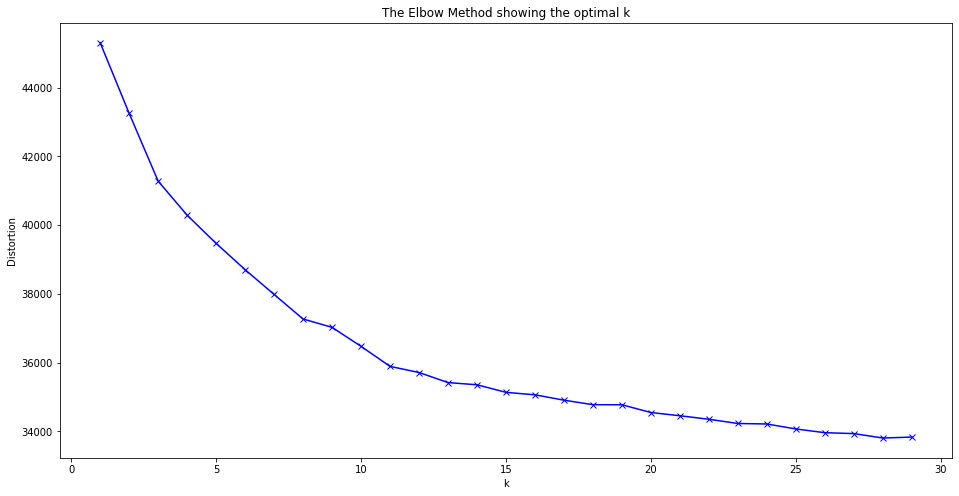

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
#Notes from Jay
#run kmeans instead on the full sentence so that the connective is 
#appropriately contextualized

# Then either concatenate the connective's embedding on its own
# to the end of the sentence
# or some other transformation dot(full_sentence, connective)
# and pass that through into k-means
# also dont forget to put the entire sentence as lowercase
# or uppercase if you feel angry.

# t-SNE Visualization using KMeans Clusters

https://builtin.com/data-science/unsupervised-learning-python
"One of the unsupervised learning methods for visualization is t-distributed stochastic neighbor embedding, or t-SNE. It maps high-dimensional space into a two or three-dimensional space which can then be visualized. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability"

In [ ]:
# Defining Model
model = TSNE(learning_rate=100)
# Fitting Model
transformed = model.fit_transform(X)
num_clusters = 11 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* a

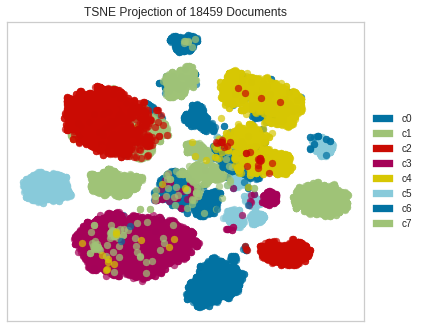

In [ ]:
from yellowbrick.text import TSNEVisualizer
clusters = KMeans(n_clusters=num_clustesrs)
clusters.fit(transformed)

tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()

In [ ]:
labels_tSNE,connective_to_label_tSNE = view_labels(X, X_sentences, clusters.labels_, num_clusters)

NameError: ignored

In [ ]:
labels_tSNE

[[0,
  [{'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as an alternative',
    'as well',
    'before',
    'besides',
    'but',
    'by then',
    'else',
    'finally',
    'for',
    'however',
    'if',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'insofar as',
    'later',
    'likewise',
    'moreover',
    'on the contrary',
    'regardless',
    'separately',
    'specifically',
    'then',
    'though',
    'ultimately',
    'whereas'}]],
 [1,
  [{'and',
    'but',
    'by comparison',
    'by contrast',
    'however',
    'in contrast',
    'meantime',
    'meanwhile',
    'nevertheless',
    'nonetheless',
    'on the one hand on the other hand',
    'on the other hand',
    'still',
    'though',
    'whereas',
    'while',
    'yet'}]],
 [2,
  [{'also',
    'and',
    'as',
    'as though',
    'conversely',
    'indeed',
    'much as',
    'overall'}]],
 [3,
  

In [ ]:
connective_to_label_tSNE

# Affinity Propogation

https://scikit-learn.org/stable/modules/clustering.html
"AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given."

Not enough RAM to do this

In [ ]:
from sklearn.cluster import AffinityPropagation
# Fit Affinity Propagation with Scikit
afprop = AffinityPropagation(max_iter=250)
afprop.fit(X)
cluster_centers_indices = afprop.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
# Predict the cluster for all the samples
P = afprop.predict(X)


# Mean-Shift

https://scikit-learn.org/stable/modules/clustering.html

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

In [ ]:
from sklearn.cluster import MeanShift
ms = MeanShift(max_iter = 10)
ms.fit(X)

KeyboardInterrupt: ignored

In [ ]:
num_clusters = len(set(ms.labels))
labels_MS,connective_to_label_MS = view_labels(X, X_sentences, ms.labels, num_clusters)



# Hierarchal Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 4).fit(X)
clustering.labels_

# DBSCAN

Following: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

the linear boundary of the k-means clustering definitely does not work well. However, DBSCAN doesn’t require any shape of the clusters but tracks the high-density regions

There are a few implicit assumptions in this approach:
*   Densities across all the clusters are the same.
*   Cluster sizes or standard deviations are the same.


A large eps tend to include more points within a cluster, so a too-large eps will include everything in the same single cluster and a too-small eps will result in no clustering at all.

A too-small minPts is not meaningful because it will regard every point as a core point. A relatively larger minPts can be better to deal with data with more noises.

In [ ]:
#use nearest neighbors to help calculate our eps argument with dbscan

In [ ]:
from sklearn.neighbors import NearestNeighbors
#https://scikit-learn.org/stable/modules/neighbors.html
#start by using sqrt(N) for number of neighbors

#two different approaches
#num_neighs = round(len(X)/11) #naively we expect around 11 clusters 
num_neighs = round(np.sqrt(len(X))) #naive estimation of the number of neighbors to use in algorithms like this 

nearest_neighbors = NearestNeighbors(n_neighbors=num_neighs)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

Text(0, 0.5, 'Distance')

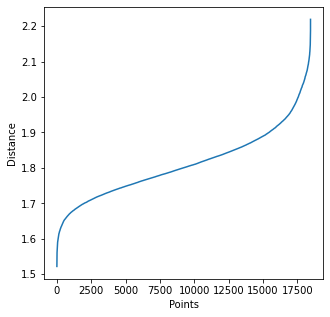

In [ ]:
#plot
distances_sorted = np.sort(distances[:,num_neighs-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances_sorted)
plt.xlabel("Points")
plt.ylabel("Distance")

#When num_neighs = len(X)/11 -- could look at other elbow point in data

1.9129465


<Figure size 360x360 with 0 Axes>

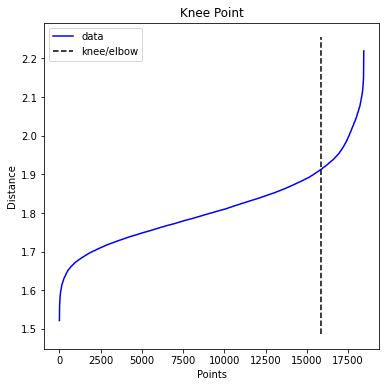

In [ ]:
#find eps from the above graph using KneeLocator to Detect Elbow Point
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances_sorted, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(knee.knee_y)

In [ ]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=eps, min_samples=num_neighs).fit(X)
#print(DBSCAN_cluster.labels_)

In [ ]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("percentage of points that are outliers: " + str(percentage_outliers))

Num_outliers: 164
percentage of points that are outliers: 0.8884554959640283


In [ ]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1
labels_DBSCAN,connective_to_label_DBSCAN = view_labels(X, X_sentences, DBSCAN_labels, len(set(DBSCAN_labels)))

In [ ]:
labels_DBSCAN

[[0,
  [{'as a result',
    'as if',
    'as long as',
    'as though',
    'besides',
    'by comparison',
    'by contrast',
    'consequently',
    'either or',
    'finally',
    'for',
    'further',
    'in contrast',
    'in fact',
    'in other words',
    'in short',
    'in sum',
    'in the end',
    'later',
    'lest',
    'much as',
    'neither nor',
    'next',
    'nor',
    'on the contrary',
    'once',
    'or',
    'otherwise',
    'overall',
    'previously',
    'rather',
    'separately',
    'similarly',
    'simultaneously',
    'so that',
    'specifically',
    'thereby',
    'therefore',
    'unless',
    'yet'}]],
 [1,
  [{'And',
    'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'before and after',
    'besides',
